## librerias

In [65]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [66]:
%run codigos/R_Fresnel.ipynb
%run codigos/mv_to_ep.ipynb

## Parametros globales de la antena

In [67]:
#-----------------------------------
## Parámetros globales de la antena
#-----------------------------------

Fs = 23.328e9 #Frecuencia de muestreo [Hz] 
Ts = 1/Fs
BW = 1.5e9 
corte = 150
Nfft= 1024 # nro de frecs -> conviene que sea multiplo de 2 para calcular la FFT de manera eficiente. 
#Tiene que ser mayor a la longitud de la señal (285 para 2m, 439 para 3m)

#------------------------------
##Elegir frecuencia portadora
#------------------------------
portadora = input('portadora? (Fc7 o Fc8)')

if portadora == 'Fc7':
    fc = 7.290e9 
    Fc = '7.29GHz'
elif portadora == 'Fc8':
    fc = 8.748e9
    Fc = '8.74GHz'
else:
    print('Error: portadora debe ser Fc7 o Fc8')

In [68]:
#------------------------------
##Elegir fecha de mediciones
#------------------------------
mes = input('mes? (mayo, junio, julio o agosto)')

with open('Mediciones/'+mes+'_'+portadora+'.pkl','rb') as g:
    Med = pickle.load(g)
print(Med.keys())
with open('Mediciones/hydra_'+mes+'.pkl','rb') as gg:
    hydra = pickle.load(gg)
print(hydra.keys())

dict_keys(['h1_may', 'h2_may', 'f_may', 'S1_may', 'S2_may'])
dict_keys(['depth_may', 'mv_med_may', 'ep_med_may', 'sigma_may'])


## Parametros del suelo

In [69]:
hydraList = list(hydra.keys())

depth = hydra.get(hydraList[0])
mv_med = hydra.get(hydraList[1])
ep_med = hydra.get(hydraList[2])
sigma = hydra.get(hydraList[3])

In [70]:
print('los valores que se midieron fueron:')
print('-profundidades desde,',np.min(depth),' a ',np.max(depth))
print('-mv desde ',np.min(mv_med),' a ',np.max(mv_med))
print('-epsilon desde ',np.min(ep_med),' a ',np.max(ep_med))
print()

#grilla de valores para MV
mv_min = 1*np.min(mv_med)
mv_max = 1.25*np.max(mv_med)
n_mv = 100
MV = np.linspace(mv_min,mv_max,n_mv)

Sand = 0.5
Clay = 0.5

ep_teo = mv_to_ep(MV,Sand,Clay,0)['ep']

#usando el error
#ep_std = 0.01 #std para estimar el error en ep del modelo teórico
#ep_teo = mv_to_ep(MV,Sand,Clay,ep_std)['ep']
#ep_error = mod.mv_to_ep(MV,Sand, Clay,ep_std)['ep_error']

ep_min, ep_max = np.min(ep_teo), np.max(ep_teo)
print('epsilon calculado con el modelo de hallikainen:')
print('epsilon teorico: ',ep_min,' - ',ep_max)
print()



los valores que se midieron fueron:
-profundidades desde, 0.02  a  0.12
-mv desde  0.292  a  0.376
-epsilon desde  (18.674+7.424j)  a  (25.813+10.474j)

epsilon calculado con el modelo de hallikainen:
epsilon teorico:  (12.877284+3.1228394959999997j)  -  (22.9023775+5.212148849999998j)



# Mediciones S1 vs S2

In [71]:
keysList = list(Med.keys())
if mes == 'agosto':
    h1 = Med.get(keysList[0])
    h2 = h1
    f = Med.get(keysList[1])
    S1 = Med.get(keysList[2])
    S2 = Med.get(keysList[4])
    S1B = Med.get(keysList[3])
else:
    h1 = Med.get(keysList[0])
    h2 = Med.get(keysList[1])
    f = Med.get(keysList[2])
    S1 = Med.get(keysList[3])
    S2 = Med.get(keysList[4])
    


## Modelo rugoso

### Una capa
<!-- \epsilon_0
~~~~~~~~~~~~~
\epsilon_1
~~~~~~~~~~~~~
\epsilon_2 -->



Seguimos el modelo del paper "Degree of roughness of rough layers" - pinel (2010)

\begin{equation}
<E_t>=<E_{r1}>+<E_{r2}>
\end{equation}

\begin{cases}
<E_{r1}>=R_{01}E_ie^{-2k_{0z}^2\sigma_a^2}\\
<E_{r2}>=T_{01}R_{12}T_{10}E_ie^{i2k_{1z}d}e^{-(k_{0z}-k_{1z})^2\sigma_a^2}e^{-k_{1z}^2\sigma_b^2}
\end{cases}

donde

$d$ es el ancho de la capa

$R_{ij}$ y $T_{ij}$ son los coeficienes de reflexion de fresnel

$k_{0z}=\frac{2\pi f}{c}\sqrt{\epsilon_0}cos(\theta_0)$ (obs: aire $\epsilon_0=1$)

$k_{1z}=\frac{2\pi f}{c}\sqrt{\epsilon_1}cos(\theta_1)$ con $cos(\theta_1)=\sqrt{1-\frac{\epsilon_0}{\epsilon_1}sen^2(\theta_0)}$

$\sigma_a$ y $\sigma_b$ son la altura RMS (root mean square) de las capas

In [72]:
def Rf_2(ep1,ep2,d,tita,f,rms1,rms2):
    #---------coef fresnel-----------
    #por snell
    tita_1 = np.arcsin(np.sin(tita)/np.sqrt(ep1))

    R01 = R_ij(1,ep1,tita, tita_1)
    T01 = T_ij(1,ep1,tita,tita_1)
    T10 = T_ij(ep1,1,tita_1,tita)

    #por snell
    tita_2 = np.arcsin(np.sqrt(ep1/ep2)*np.sin(tita_1))
    R12 = R_ij(ep1,ep2,tita_1,tita_2)
    #--------------------------------

    #--------kiz---------------------
    k0z = (2*np.pi*f*np.cos(tita))/3e8
    k1z = (2*np.pi*f+np.sqrt(ep1)*np.cos(tita_1))/3e8
    #--------------------------------

    Rf1 = R01*np.exp(-2*k0z**2*rms1**2)
    Rf2 = T01*R12*T10*np.exp(2*1j*k1z*d)*np.exp(-(k0z-k1z)**2*rms1**2)*np.exp(-2*k1z**2*rms2**2)
    Rft = Rf1+Rf2
    return Rft



In [88]:
#----------------Parametros-----------------------
# grillado de epsilon
n_ep = 20
ep1Range = np.linspace(ep_min,0.6*ep_max,n_ep)
ep2Range = np.linspace(0.4*ep_max,1.25*ep_max,n_ep)
print('------------------------------')
print('grillado de valores de epsilon')
print('------------------------------')
print('ep1:',ep1Range[0],'-',ep1Range[-1])
print('ep2:',ep2Range[0],'-',ep2Range[-1])
print()


# espesor de la capa
d_min, d_max, n_d = 0.010, 0.08, 10
dRange = np.linspace(d_min,d_max,n_d)
print('------------------------------')
print('espesor de la capa')
print('------------------------------')
print('d:',np.min(dRange)*100,'cm -',np.max(dRange)*100,'cm')
print()

# altura rms de las dos superficies
n_rms = n_d
rms1Range = np.linspace(0.1e-3,5e-3,n_rms)
rms2Range = np.linspace(0.5e-4,0.1e-3,n_rms)
print('------------------------------')
print('alturas RMS')
print('------------------------------')
print('sigma_a:',np.min(rms1Range)*100,'mm -',np.max(rms1Range)*100,'mm')
print('sigma_b:',np.min(rms2Range)*100,'mm -',np.max(rms2Range)*100,'mm')



------------------------------
grillado de valores de epsilon
------------------------------
ep1: (12.877284+3.1228394959999997j) - (13.7414265+3.1272893099999988j)
ep2: (9.160951+2.0848595399999996j) - (28.627971875+6.515186062499998j)

------------------------------
espesor de la capa
------------------------------
d: 1.0 cm - 8.0 cm

------------------------------
alturas RMS
------------------------------
sigma_a: 0.01 mm - 0.5 mm
sigma_b: 0.005 mm - 0.01 mm


### Loop

In [89]:
# vector para guardar el error
Errores = np.zeros((n_d,n_ep,n_ep,n_rms,n_rms),dtype=float)

# vector en donde guardo la señal teórica que mejor ajusta a cada medición
D_opt = np.zeros(len(h1), dtype=float)
EP1_opt = np.zeros(len(h1), dtype=complex)
EP2_opt = np.zeros(len(h1), dtype=complex)
RMS1_opt = np.zeros(len(h1), dtype=float)
RMS2_opt = np.zeros(len(h1), dtype=float)

plt.figure()
#for i in range(len(h1)):
    for i0 in range(n_d):
        D = dRange[i0]
        for i1 in range(n_ep):
            EP1 = ep1Range[i1]
            for i2 in range(n_ep):
                EP2 = ep2Range[i2]
                for i3 in range(n_rms):
                    RMS1 = rms1Range[i3]
                    for i4 in range(n_rms):
                        RMS2 = rms2Range[i4]

                        # coef rugosidad
                        R = Rf_2(EP1,EP2,D,0,f,RMS1,RMS2)
                        S2_teo = S1[i]*R
                
                        ## Calculo métricas de error #
                        #Errores[i0,i1,i2,i3,i4] = np.sum(np.abs(np.sqrt(S2_teo**2)-np.sqrt(S2[i]**2)))/len(S2_teo)  ## error absoluto medio
                        Errores[i0,i1,i2,i3,i4] = np.sqrt(np.sum((np.abs(S2_teo)-np.abs(S2[i]))**2)/len(S2_teo)) ##RMS deviation

    print('altura: h = ',h1[i])
    print('indices optimos:', np.unravel_index(Errores.argmin(),Errores.shape))

    indice_d_opt = np.unravel_index(Errores.argmin(),Errores.shape)[0]
    D_opt[i] = dRange[indice_d_opt]

    indice_ep1_opt = np.unravel_index(Errores.argmin(),Errores.shape)[1]
    EP1_opt[i] = ep1Range[indice_ep1_opt]

    indice_ep2_opt = np.unravel_index(Errores.argmin(),Errores.shape)[2]
    EP2_opt[i] = ep2Range[indice_ep2_opt]

    indice_rms1_opt = np.unravel_index(Errores.argmin(),Errores.shape)[3]
    RMS1_opt[i] = rms1Range[indice_rms1_opt]

    indice_rms2_opt = np.unravel_index(Errores.argmin(),Errores.shape)[4]
    RMS2_opt[i] = rms2Range[indice_rms2_opt]



altura: h =  0.365
indices optimos: (9, 0, 19, 0, 0)
altura: h =  0.47
indices optimos: (9, 0, 19, 0, 0)
altura: h =  0.665
indices optimos: (9, 0, 19, 0, 0)
altura: h =  0.865
indices optimos: (9, 0, 19, 0, 0)


<Figure size 432x288 with 0 Axes>

In [77]:
# Guardamos los indices optimos 
id_opt = {
    'D_opt' : D_opt,
    'EP1_opt' : EP1_opt,
    'EP2_opt' : EP2_opt,
    'RMS1_opt' : RMS1_opt,
    'RMS2_opt' : RMS2_opt
}

pkl = open('Mediciones/id_opt_'+mes+'.pkl',"wb") #Wb : write binary
pickle.dump(id_opt,pkl) # write the python object (dict) to pickle file
pkl.close()

## Graficos


In [ ]:
## por si quiero graficar cosas sin correr el grillado, importo indices
# with open('Mediciones/id_opt_'+mes+'.pkl','rb') as kkk:
#     ID = pickle.load(kkk)
# ID_list = list(ID.keys())

# D_opt = ID.get(ID_list[0])
# EP1_opt = ID.get(ID_list[1])
# EP2_opt = ID.get(ID_list[2])
# RMS1_opt = ID.get(ID_list[3])
# RMS2_opt = ID.get(ID_list[4])


2


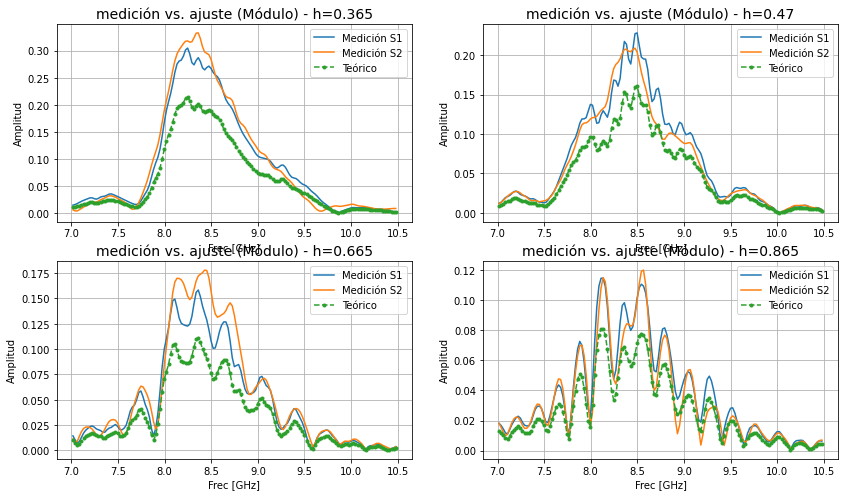

In [84]:
#grafico para diferentes alturas
n = int(len(h1)/2)
print(n)
fig , ax = plt.subplots(nrows=n, ncols=n, figsize=(14,8))
for i1 in range(n):
        for i2 in range(n):
            i0 = int(2*i1+i2)
            # Señal optima:
            Rf_opt = Rf_2(EP1_opt[i0],EP2_opt[i0],D_opt[i0],0,f,RMS1_opt[i0],RMS2_opt[i0]) 
            S2_opt = S1[i0,:]*Rf_opt
            ax[i1,i2].plot(f,np.abs(S1[i0,:]),label='Medición S1')
            ax[i1,i2].plot(f,np.abs(S2[i0,:]),label='Medición S2')
            ax[i1,i2].plot(f,np.abs(S2_opt),'--.',label='Teórico')
            ax[i1,i2].grid('on')
            ax[i1,i2].legend(loc="best",fontsize=10)
            ax[i1,i2].set_xlabel('Frec [GHz]')
            ax[i1,i2].set_ylabel('Amplitud')
            ax[i1,i2].set_title( 'medición vs. ajuste (Módulo) - h='+str(h1[i0]), fontsize=14) #, fontstyle='normal')

# plt.savefig(os.path.join('graficos','S2_rugoso_agostoB.png'))

## Valores a mano

COMPLETAR EN SEÑALES.IPYNB: HACER UN PROMEDIO DE LAS MEDICIONES DE S1 PARA VER SI AJUSTAN MEJOR CON LOS VALORES MEDIDOS DE S2

In [96]:
#probamos con las señales S1 de junio porque las de mayo son raras
with open('Mediciones/junio_'+portadora+'.pkl','rb') as pp:
    Mmed = pickle.load(pp)
kL = list(Mmed.keys())
S1 = Mmed.get(kL[3])


(0.02, 0.025, 0.065, 0.12)
((20.731+8.688j), (18.674+7.424j), (23.299+9.799j), (25.813+10.474j))


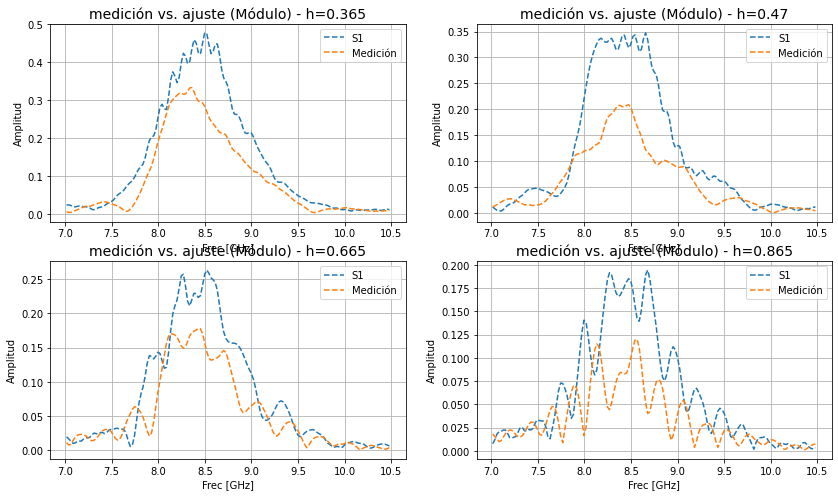

In [97]:
print(depth)
print(ep_med)

D = 0.1
EP1a = 20.731+40j
EP1b = 20.731+8.688j
EP2a = 23+60j
EP2b = 23.299+9.799j
RMS1 = 0.001
RMS2 = 0.0001

fig , ax = plt.subplots(nrows=2, ncols=2, figsize=(14,8))
for i1 in range(2):
        for i2 in range(2):
            i0 = int(2*i1+i2)
            
            # Señal:
            Rf1 = Rf_2(EP1a,EP2a,D,0,f,RMS1,RMS2) 
            S2_teo1 = S1[i0,:]*Rf1
            
            Rf2 = Rf_2(EP1b,EP2b,D,0,f,RMS1,RMS2) 
            S2_teo2 = S1[i0,:]*Rf2

            ax[i1,i2].plot(f,np.abs(S1[i0,:]),'--',label='S1')
            ax[i1,i2].plot(f,np.abs(S2[i0,:]),'--',label='Medición')
            #ax[i1,i2].plot(f,np.abs(S2_teo1),'-.',label='Teórico 1')
            #ax[i1,i2].plot(f,np.abs(S2_teo2),'-.',label='Teórico 2')
            ax[i1,i2].grid('on')
            ax[i1,i2].legend(loc="best",fontsize=10)
            ax[i1,i2].set_xlabel('Frec [GHz]')
            ax[i1,i2].set_ylabel('Amplitud')
            ax[i1,i2].set_title( 'medición vs. ajuste (Módulo) - h='+str(h1[i0]), fontsize=14) #, fontstyle='normal')

### Dos capas
<!-- \epsilon_0
~~~~~~~~~~~~~    0
\epsilon_1
~~~~~~~~~~~~~   d1
\epsilon_2 
~~~~~~~~~~~~~   d2
\epsilon_3
-->



Seguimos el modelo del paper "Degree of roughness of rough layers" - pinel (2010)

\begin{equation}
<E_t>=<E_{r1}>+<E_{r2}>+<E_{r3}>
\end{equation}

\begin{cases}
<E_{r1}>=R_{01} E_i e^{-2k_{0z}^2\sigma_a^2}\\
<E_{r2}>=T_{01}R_{12}T_{10} E_i e^{i2k_{1z}d_1} e^{-(k_{0z}-k_{1z})^2\sigma_a^2} e^{-k_{1z}^2\sigma_b^2}\\
<E_{r3}>=T_{01}T_{12}R_{23}T_{21}T_{10} E_i e^{i2[(k_{1z}-k_{2z})d_1+k_{2z}d_2]} e^{-(k_{0z}-k_{1z})^2\sigma_a^2} e^{-(k_{1z}-k_{2z})^2\sigma_b^2}e^{-k_{2z}^2\sigma_c^2}
\end{cases}

donde

$d1$, $d2$ son los anchos de las capas

$R_{ij}$ y $T_{ij}$ son los coeficienes de reflexion de fresnel

$k_{0z}=\frac{2\pi f}{c}\sqrt{\epsilon_0}cos(\theta_0)$ (obs: aire $\epsilon_0=1$)

$k_{1z}=\frac{2\pi f}{c}\sqrt{\epsilon_1}cos(\theta_1)$ con $cos(\theta_1)=\sqrt{1-\frac{\epsilon_0}{\epsilon_1}sen^2(\theta_0)}$

$k_{2z}=\frac{2\pi f}{c}\sqrt{\epsilon_2}cos(\theta_2)$ con $cos(\theta_2)=\sqrt{1-\frac{\epsilon_1}{\epsilon_2}sen^2(\theta_1)}$

$\sigma_a$, $\sigma_b$ y $\sigma_c$ son la altura RMS (root mean square) de las capas

In [ ]:
def Rf_3(ep1,ep2,ep3,d1,d2,tita_0,f,rms1,rms2,rms3):
    #---------coef fresnel-----------
    #por snell
    tita_1 = np.arcsin(np.sin(tita_0)/np.sqrt(ep1))

    R01 = R_ij(1,ep1,tita_0, tita_1)
    T01 = T_ij(1,ep1,tita_0,tita_1)
    T10 = T_ij(ep1,1,tita_1,tita_0)

    #por snell
    tita_2 = np.arcsin(np.sqrt(ep1/ep2)*np.sin(tita_1))
    R12 = R_ij(ep1,ep2,tita_1,tita_2)
    T12 = R_ij(ep1,ep2,tita_1,tita_2)
    T21 = R_ij(ep1,ep2,tita_1,tita_2)

    #por snell
    tita_3 = np.arcsin(np.sqrt(ep2/ep3)*np.sin(tita_2))
    R23 = R_ij(ep2,ep3,tita_2,tita_3)
    #--------------------------------

    #--------kiz---------------------
    k0z = (2*np.pi*f*np.cos(tita_0))/3e8
    k1z = (2*np.pi*f+np.sqrt(ep1)*np.cos(tita_1))/3e8
    k2z = (2*np.pi*f+np.sqrt(ep2)*np.cos(tita_2))/3e8
    #--------------------------------

    Rf1 = R01*np.exp(-2*k0z**2*rms1**2)
    Rf2 = T01*R12*T10*np.exp(2*1j*k1z*d)*np.exp(-(k0z-k1z)**2*rms1**2)*np.exp(-2*k1z**2*rms2**2)
    
    phi = -[(k0z-k1z)*rms1]**2-[(k1z-k2z)*rms2]**2-2*[k2z*rms3]**2
    Rf3 = T01*T12*R23*T21*T10*np.exp(2*1j*[(k1z-k2z)*d1+k2z*d2])*np.exp(phi)
    
    Rft = Rf1+Rf2+Rf3
    return Rft

